# An LLM for Script Writing

As the [book](https://www.manning.com/books/causal-ai) details:

> Suppose a prolific film production studio has historically insisted their writers use script-writing software that required following a three-act narrative archetype...for this archetype, they have a corpus of many scripts. In causal terms, the events in act 1 cause the events of act 2, and the events of acts 1 and 2 cause the events of act 3

In this example the movie studio wants to develop a script with the following three act narrative:

> a king acting a certain way in act 1, a prince acting a certain way in act 2, and these two actions having an effect on a kingdom in act 3.

Under such a scenerio there are 27 possible archetypes (i.e., 3*3*3) such as King declares ware in act 1, prince leads army in act 2 and kingom falls in act 3.

This King-Prince-Kingom archetype can be represented by the following causal DAG:


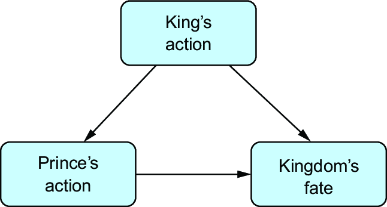

In [1]:
# loading causal narrative data
import pandas as pd
import os
os.environ["WANDB_DISABLED"] = "true"
url = "https://raw.githubusercontent.com/altdeep/causalML/refs/heads/master/book/chapter%2013/king-prince-kingdom.csv"
df = pd.read_csv(url)
print(f'Number of narrative stories: {df.shape[0]}')
print(f"First the King acts: {df['King'][0]}")
print(f"Second the prince acts: {df["Prince"][0]}")
print(f"Last the kingdom: {df["Kingdom"][0]}")

Number of narrative stories: 21737
First the King acts: King secures a fragile peace through diplomacy
Second the prince acts: his son, the Prince, marries a foreigner to strengthen alliances
Last the kingdom: however, unforeseen economic hardships befall the kingdom, leading to widespread poverty."


## Using Pretrained Models for Causal Markov Kernels

As the [book](https://www.manning.com/books/causal-ai) details:

> To train the causal Markov kernels for each node in our DAG, we’ll take pretrained models from the Hugging Face Transformers library, and then further train (aka “fine-tune”) the models using our vignettes [i.e., narrative stories].

We will use GPT-2 to model the Kings action and BART to model the Prince's action and the Kingdom's fate. Also since we are interested in the conditional probability distribution of the Kindom's fate given actions of the Prince, BART will also model the Kings action given the Prince's action.

The following causal process along with the pretrained models is represented below:

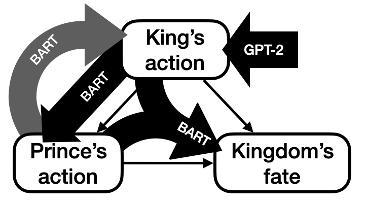

In [2]:
# Training the causal LLM
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from transformers import (
    AutoModelForCausalLM, AutoModelForSeq2SeqLM,
    AutoTokenizer, DataCollatorForLanguageModeling,
    Seq2SeqTrainer, Seq2SeqTrainingArguments,
    Trainer, TrainingArguments)

# getting narritave data
url = ("https://raw.githubusercontent.com/altdeep/"
       "causalML/master/book/chapter%2013/"
       "king-prince-kingdom-updated.csv")
df = pd.read_csv(url)

# setting up tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
# padding tokens to be same length
tokenizer.pad_token = tokenizer.eos_token
# func to set max length of tokens to 40
def tokenize_phrases(phrases, max_length=40):
    return tokenizer(
        phrases,
        truncation=True,
        padding='max_length',
        max_length=max_length
    )

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [3]:
# examining narriative data
df.head()

,king,kingdom,prince,King,Prince,Kingdom
0,King negotiates peace,Kingdom falls into poverty,Prince marries foreigner,King brokers a peace treaty with a rival kingd...,"however, his son, the Prince, falls in love an...","despite efforts, the ongoing war results in bo..."
1,King negotiates peace,Kingdom wins battle,Prince marries foreigner,A wise king successfully negotiates peace with...,Prince falls in love with and marries a foreig...,"the alliance strengthens their forces, leading..."
2,King negotiates peace,Kingdom falls into poverty,Prince leads army,A wise king successfully negotiates peace betw...,"but when a new threat emerges, the Prince lead...","however, a series of misfortunes and disastrou..."
3,King declares war,Kingdom experiences prosperity,Prince abdicates throne,King announces war to defend his kingdom,"conflicted by the responsibility, the prince a...","under his worthy leadership, the kingdom exper..."
4,King falls ill,Kingdom experiences prosperity,Prince abdicates throne,"A beloved king falls gravely ill, leaving his ...","however, his own son, the Prince, abandons his...","the unified kingdoms flourish together, sharin..."


In [4]:
# tokenizing and creating training data for king
class ModelDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        }
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

def create_king_dataset(input_phrases):
    king_phrases = input_phrases.tolist()
    king_encodings = tokenize_phrases(king_phrases)
    king_dataset = ModelDataset(
        king_encodings,
        king_encodings['input_ids'])
    return king_dataset

In [5]:
# tokenizing and creating training/validation data for prince and kingdom
def create_seq2seq_datasets(input_phrases, target_phrases):
    input_phrases_list = input_phrases.tolist()
    target_phrases_list = target_phrases.tolist()
    spit = train_test_split(
        input_phrases_list,
        target_phrases_list,
        test_size=0.1
    )
    train_inputs, val_inputs, train_targets, val_targets = spit
    train_input_encodings = tokenize_phrases(train_inputs)
    val_input_encodings = tokenize_phrases(val_inputs)
    train_target_encodings = tokenize_phrases(train_targets)
    val_target_encodings = tokenize_phrases(val_targets)
    train_dataset = ModelDataset(
        train_input_encodings, train_target_encodings['input_ids']
    )
    val_dataset = ModelDataset(
        val_input_encodings, val_target_encodings['input_ids']
    )
    return train_dataset, val_dataset

In [10]:
# function to train king model
def train_king_model(output_dir, train_dataset,
                     model_name="gpt2-medium", epochs=4):

    king_model = AutoModelForCausalLM.from_pretrained(model_name)

    training_args_king = TrainingArguments(
      output_dir=output_dir,
      per_device_train_batch_size=32,
      overwrite_output_dir=True,
      num_train_epochs=epochs,
      save_total_limit=1,
      save_steps=len(train_dataset) // 16,
      max_grad_norm=1.0,
      report_to=None
    )

    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False)

    trainer_king = Trainer(
        model=king_model,
        args=training_args_king,
        data_collator=data_collator,
        train_dataset=train_dataset,
    )

    trainer_king.train()
    king_model.save_pretrained(output_dir)
    return king_model

In [11]:
# function to train prince and kingdom model
def train_seq2seq_model(output_dir, train_dataset, val_dataset,
                        model_name="facebook/bart-base",
                        epochs=4):

    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    training_args = Seq2SeqTrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=16,
        predict_with_generate=True,
        logging_dir=f"{output_dir}/logs",
        save_total_limit=1,
        save_steps=len(train_dataset) // 16,
        learning_rate=3e-5,
        num_train_epochs=epochs,
        warmup_steps=500,
        weight_decay=0.01,
        report_to=None
    )

    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )

    trainer.train()
    model.save_pretrained(output_dir)
    return model

In [12]:
# calling the above functions to finetune pretrained LLMs

import os

king_model_path = os.path.join(os.getcwd(), 'king_model')
prince_model_path = os.path.join(os.getcwd(), 'prince_model')
kingdom_model_path = os.path.join(os.getcwd(), 'kingdom_model')
prince2king_model_path = os.path.join(
    os.getcwd(), 'prince2king_model')

# finetuning King model
king_dataset = create_king_dataset(df["King"])
king_model = train_king_model(king_model_path, king_dataset)

# finetuning Prince model
datasets = create_seq2seq_datasets(df["King"], df["Prince"])
train_dataset_prince, val_dataset_prince = datasets
prince_model = train_seq2seq_model(
    prince_model_path,
    train_dataset_prince,
    val_dataset_prince,
    epochs=6
)

# finetuning kingdom model
king_and_prince = [f"{k} {p}" for k, p in zip(df["King"], df["Prince"])]
df["King and Prince"] = king_and_prince
train_dataset_kingdom, val_dataset_kingdom = create_seq2seq_datasets(
    df["King and Prince"], df["Kingdom"]
)
kingdom_model = train_seq2seq_model(
    kingdom_model_path,
    train_dataset_kingdom,
    val_dataset_kingdom,
   epochs=6
)

# finetuning prince2king model
p2k_data = create_seq2seq_datasets(
    df["Prince"], df["King"])
train_dataset_prince2king, val_dataset_prince2king = p2k_data
prince2king_model = train_seq2seq_model(
    prince2king_model_path,
    train_dataset_prince2king,
    val_dataset_prince2king,
    epochs=6
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
500,1.671100
1000,1.124000
1500,1.009200
2000,0.948100
2500,0.895500


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,1.081600
1000,0.664900
1500,0.609800
2000,0.582800
2500,0.565000
3000,0.546000
3500,0.543000
4000,0.522800
4500,0.526700
5000,0.511000


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3917: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,1.324400
1000,0.901600
1500,0.837300
2000,0.805700
2500,0.776800
3000,0.749400
3500,0.744100
4000,0.719900
4500,0.713600
5000,0.700200


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3917: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.678700
1000,0.389700
1500,0.359100
2000,0.350700
2500,0.340700
3000,0.333100
3500,0.328000
4000,0.321800
4500,0.320200
5000,0.316600


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3917: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


In [16]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import torch
# from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import (
     AutoModelForCausalLM, AutoModelForSeq2SeqLM,
     AutoTokenizer, GPT2LMHeadModel,
     PreTrainedModel, BartForConditionalGeneration)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# king_model = AutoModelForCausalLM.from_pretrained(     #1
#     "osazuwa/causalLLM-king").to(DEVICE)    #1
# prince_model = AutoModelForSeq2SeqLM.from_pretrained(    #1
#     "osazuwa/causalLLM-prince").to(DEVICE)    #1
# kingdom_model = AutoModelForSeq2SeqLM.from_pretrained(    #1
#     "osazuwa/causalLLM-kingdom").to(DEVICE)     #1
# prince2king_model = AutoModelForSeq2SeqLM.from_pretrained(     #1
#     "osazuwa/causalLLM-prince2king").to(DEVICE)     #1

# tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")    #2
# tokenizer.pad_token = tokenizer.eos_token

In [17]:
def encode(text:str, device=DEVICE) -> torch.tensor:
    input_ids = tokenizer.encode(text, return_tensors="pt")
    input_ids = input_ids.to(device)
    return input_ids

def decode(text_ids: torch.tensor) -> str:
    output = tokenizer.decode(text_ids, skip_special_tokens=True)
    return output

EMPTY_TEXT = torch.tensor(tokenizer.encode("")).unsqueeze(0).to(DEVICE)

def generate_from_model(model: PreTrainedModel,
                        input_sequence: torch.tensor = EMPTY_TEXT,
                        max_length: int = 25,
                        temperature=1.0):
    output = model.generate(
        input_sequence,
        max_length=max_length,
        do_sample=True,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.pad_token_id,
        temperature=temperature,
        top_p=0.9,
    )
    return output

def convert_to_text(output):
    return decode(output[0]).strip().capitalize()

In [ ]:
# def compute_log_probs(model, output_sequence):
#     if isinstance(model, GPT2LMHeadModel):
#         outputs = model(
#             input_ids=output_sequence,
#             labels=output_sequence
#         )
#         log_softmax = torch.nn.functional.log_softmax(
#             outputs.logits, dim=-1)
#         log_probs = log_softmax.gather(2, output_sequence.unsqueeze(-1))
#         log_probs = log_probs.squeeze(-1).sum(dim=-1)
#     elif isinstance(model, BartForConditionalGeneration):
#         outputs = model(
#             input_ids=output_sequence,
#             labels=output_sequence)
#         loss = outputs.loss
#         log_probs = -loss * output_sequence.size(1)
#     else:
#         raise ValueError("Unsupported model type")
#     return torch.tensor(log_probs.item())

In [20]:
king_output = generate_from_model(king_model)
king_statement = convert_to_text(king_output)
print("Generated from king_nodel:", king_statement)
# log_prob_king = compute_log_probs(king_model, king_output)
# print("Log prob of generated king text:", log_prob_king)

prince_output = generate_from_model(prince_model, king_output)
prince_statement = convert_to_text(prince_output)
print("Generated from prince_model:", prince_statement)
# log_prob_prince = compute_log_probs(prince_model, prince_output)
# print("Log prob of generated prince text:", log_prob_prince)

king_prince_statement = king_statement + ". " + prince_statement
king_prince_output = encode(king_prince_statement)
kingdom_output = generate_from_model(kingdom_model, king_prince_output)
kingdom_statement = convert_to_text(kingdom_output)

print("Generated from kingdom model:", kingdom_statement)
# log_prob_kingdom = compute_log_probs(kingdom_model, kingdom_output)
# print("Log prob of generated kingdom text:", log_prob_kingdom)

king_output_infer = generate_from_model(prince2king_model, prince_output)
king_statement_infer = convert_to_text(king_output_infer)
print("Generated statement from prince2king:", king_statement_infer)
# log_prob_prince2king = compute_log_probs(prince2king_model, prince_output)
# print("Log prob of generated inference text:", log_prob_prince2king)

Generated from king_nodel: King declares war on a neighboring nation to expand his kingdom's territory and resources thin for a new territory expansion his subjects
Generated from prince_model: His son, the prince, falls in love with and marries a foreign princess, forging a powerful alliance
Generated from kingdom model: Under the prince's guidance, the kingdom flourishes, ushering in an era of unprecedented prosperity."
Generated statement from prince2king: A king, driven by ambition, declares war on a neighboring land


In [ ]:
# import pyro
# from pyro.distributions.torch_distribution \
# import TorchDistributionMixin

# class TransformerModelDistribution(TorchDistributionMixin):
#     def __init__(self, model: PreTrainedModel,
#                  input_encoding: torch.tensor = EMPTY_TEXT,
#                 ):
#         super().__init__()
#         self.model = model
#         self.input_encoding = input_encoding

#     def sample(self, sample_shape=torch.Size()):     #1
#         output = generate_from_model(    #1
#             self.model, self.input_encoding     #1
#         )    #1
#         return output     #1

#     def log_prob(self, value):     #2
#         return compute_log_probs(self.model, value)     #2

In [ ]:
# def causalLLM():  #1
#     king = pyro.sample(     #2
#         "King", TransformerModelDistribution(king_model)     #2
#     )    #2
#     prince = pyro.sample(     #3
#         "Prince", TransformerModelDistribution(   #3
#             prince_model, king)   #3
#     )     #3
#     king_and_prince = torch.cat([king, prince], dim=1)     #4
#     kingdom = pyro.sample(    #4
#         "Kingdom", TransformerModelDistribution(    #4
#             kingdom_model, king_and_prince)     #4
#     )    #4
#     king_text = convert_to_text(king)     #5
#     prince_text = convert_to_text(prince)    #5
#     kingdom_text = convert_to_text(kingdom)     #5
#     return king_text, prince_text, kingdom_text     #5

# for _ in range(2):     #6
#     king, prince, kingdom = causalLLM()    #6
#     vignette = " ".join([king, prince, kingdom])     #6
#     print(vignette)